In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"kuotient46","key":"b2a2084c4c7ea76a8758a3bb3154b8d1"}'}

In [0]:
ls -lha kaggle.json

-rw-r--r-- 1 root root 66 Apr 22 10:40 kaggle.json


In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c 2019-2nd-ml-month-with-kakr
!unzip train.csv.zip

401 - Unauthorized
Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler #Analysis 
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import os
import gc

import lightgbm as lgb
import xgboost as xgb
!pip install catboost
import catboost as cb

import time
from datetime import datetime, timedelta,date

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage  
from scipy.spatial.distance import  pdist
from datetime import datetime

In [0]:
def get_prefix(group_col, target_col, prefix=None):
    if isinstance(group_col, list) is True:
        g = '_'.join(group_col)
    else:
        g = group_col
    if isinstance(target_col, list) is True:
        t = '_'.join(target_col)
    else:
        t = target_col
    if prefix is not None:
        return prefix + '_' + g + '_' + t
    return g + '_' + t
    
def groupby_helper(df, group_col, target_col, agg_method, prefix_param=None):
    try:
        prefix = get_prefix(group_col, target_col, prefix_param)
        print(group_col, target_col, agg_method)
        group_df = df.groupby(group_col)[target_col].agg(agg_method)
        group_df.columns = ['{}_{}'.format(prefix, m) for m in agg_method]
    except BaseException as e:
        print(e)
    return group_df.reset_index()

In [0]:
from functools import wraps
def time_decorator(func): 
    @wraps(func)
    def wrapper(*args, **kwargs):
        print("\nStartTime: ", datetime.now() + timedelta(hours=9))
        start_time = time.time()
        
        df = func(*args, **kwargs)
        
        print("EndTime: ", datetime.now() + timedelta(hours=9))  
        print("TotalTime: ", time.time() - start_time)
        return df
        
    return wrapper

class SklearnWrapper(object):
    def __init__(self, clf, params=None, **kwargs):
        #if isinstance(SVR) is False:
        #    params['random_state'] = kwargs.get('seed', 0)
        self.clf = clf(**params)
        self.is_classification_problem = True
    @time_decorator
    def train(self, x_train, y_train, x_cross=None, y_cross=None):
        if len(np.unique(y_train)) > 30:
            self.is_classification_problem = False
            
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        if self.is_classification_problem is True:
            return self.clf.predict_proba(x)[:,1]
        else:
            return self.clf.predict(x)   
    
class XgbWrapper(object):
    def __init__(self, params=None, **kwargs):
        self.param = params
        self.param['seed'] = kwargs.get('seed', 0)
        self.num_rounds = kwargs.get('num_rounds', 1000)
        self.early_stopping = kwargs.get('ealry_stopping', 100)

        self.eval_function = kwargs.get('eval_function', None)
        self.verbose_eval = kwargs.get('verbose_eval', 100)
        self.best_round = 0
    
    @time_decorator
    def train(self, x_train, y_train, x_cross=None, y_cross=None):
        need_cross_validation = True
        
        if isinstance(y_train, pd.DataFrame) is True:
            y_train = y_train[y_train.columns[0]]
            if y_cross is not None:
                y_cross = y_cross[y_cross.columns[0]]

        if x_cross is None:
            dtrain = xgb.DMatrix(x_train, label=y_train, silent= True)
            train_round = self.best_round
            if self.best_round == 0:
                train_round = self.num_rounds
            
            print(train_round)
            self.clf = xgb.train(self.param, dtrain, train_round)
            del dtrain
        else:
            dtrain = xgb.DMatrix(x_train, label=y_train, silent=True)
            dvalid = xgb.DMatrix(x_cross, label=y_cross, silent=True)
            watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

            self.clf = xgb.train(self.param, dtrain, self.num_rounds, watchlist, feval=self.eval_function,
                                 early_stopping_rounds=self.early_stopping,
                                 verbose_eval=self.verbose_eval)
            self.best_round = max(self.best_round, self.clf.best_iteration)

    def predict(self, x):
        return self.clf.predict(xgb.DMatrix(x), ntree_limit=self.best_round)

    def get_params(self):
        return self.param    
    
class LgbmWrapper(object):
    def __init__(self, params=None, **kwargs):
        self.param = params
        self.param['seed'] = kwargs.get('seed', 0)
        self.num_rounds = kwargs.get('num_rounds', 1000)
        self.early_stopping = kwargs.get('ealry_stopping', 100)

        self.eval_function = kwargs.get('eval_function', None)
        self.verbose_eval = kwargs.get('verbose_eval', 100)
        self.best_round = 0
        
    @time_decorator
    def train(self, x_train, y_train, x_cross=None, y_cross=None):
        """
        x_cross or y_cross is None
        -> model train limted num_rounds
        
        x_cross and y_cross is Not None
        -> model train using validation set
        """
        if isinstance(y_train, pd.DataFrame) is True:
            y_train = y_train[y_train.columns[0]]
            if y_cross is not None:
                y_cross = y_cross[y_cross.columns[0]]

        if x_cross is None:
            dtrain = lgb.Dataset(x_train, label=y_train, silent= True)
            train_round = self.best_round
            if self.best_round == 0:
                train_round = self.num_rounds
                
            self.clf = lgb.train(self.param, train_set=dtrain, num_boost_round=train_round)
            del dtrain   
        else:
            dtrain = lgb.Dataset(x_train, label=y_train, silent=True)
            dvalid = lgb.Dataset(x_cross, label=y_cross, silent=True)
            self.clf = lgb.train(self.param, train_set=dtrain, num_boost_round=self.num_rounds, valid_sets=[dtrain, dvalid],
                                  feval=self.eval_function, early_stopping_rounds=self.early_stopping,
                                  verbose_eval=self.verbose_eval)
            self.best_round = max(self.best_round, self.clf.best_iteration)
            del dtrain, dvalid
            
        gc.collect()
    
    def predict(self, x):
        return self.clf.predict(x, num_iteration=self.clf.best_iteration)
    
    def plot_importance(self):
        lgb.plot_importance(self.clf, max_num_features=50, height=0.7, figsize=(10,30))
        plt.show()
        
    def get_params(self):
        return self.param
    
    
@time_decorator
def get_oof(clf, x_train, y_train, x_test, eval_func, **kwargs):
    nfolds = kwargs.get('NFOLDS', 5)
    kfold_shuffle = kwargs.get('kfold_shuffle', True)
    kfold_random_state = kwargs.get('kfold_random_state', 0)
    stratified_kfold_ytrain = kwargs.get('stratifed_kfold_y_value', None)
    ntrain = x_train.shape[0]
    ntest = x_test.shape[0]
    
    kf_split = None
    if stratified_kfold_ytrain is None:
        kf = KFold(n_splits=nfolds, shuffle=kfold_shuffle, random_state=kfold_random_state)
        kf_split = kf.split(x_train)
    else:
        kf = StratifiedKFold(n_splits=nfolds, shuffle=kfold_shuffle, random_state=kfold_random_state)
        kf_split = kf.split(x_train, stratified_kfold_ytrain)
        
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))

    cv_sum = 0
    
    # before running model, print model param
    # lightgbm model and xgboost model use get_params()
    try:
        if clf.clf is not None:
            print(clf.clf)
    except:
        print(clf)
        print(clf.get_params())

    for i, (train_index, cross_index) in enumerate(kf_split):
        x_tr, x_cr = None, None
        y_tr, y_cr = None, None
        if isinstance(x_train, pd.DataFrame):
            x_tr, x_cr = x_train.iloc[train_index], x_train.iloc[cross_index]
            y_tr, y_cr = y_train.iloc[train_index], y_train.iloc[cross_index]
        else:
            x_tr, x_cr = x_train[train_index], x_train[cross_index]
            y_tr, y_cr = y_train[train_index], y_train[cross_index]

        clf.train(x_tr, y_tr, x_cr, y_cr)
        
        oof_train[cross_index] = clf.predict(x_cr)

        cv_score = eval_func(y_cr, oof_train[cross_index])
        
        print('Fold %d / ' % (i+1), 'CV-Score: %.6f' % cv_score)
        cv_sum = cv_sum + cv_score
        
        del x_tr, x_cr, y_tr, y_cr
        
    gc.collect()
    
    score = cv_sum / nfolds
    print("Average CV-Score: ", score)

    # Using All Dataset, retrain
    clf.train(x_train, y_train)
    oof_test = clf.predict(x_test)

    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1), score

In [0]:
df_train = pd.read_csv('train.csv')
df_test  = pd.read_csv('test.csv')

In [0]:
df_train = df_train.loc[df_train['bedrooms']<10]
df_train.loc[df_train['sqft_living'] > 13000]
df_train = df_train.loc[df_train['id']!=8990]
df_train.loc[(df_train['price']>12) & (df_train['grade'] == 3)]
df_train.loc[(df_train['price']>14.7) & (df_train['grade'] == 8)]
df_train.loc[(df_train['price']>15.5) & (df_train['grade'] == 11)]
df_train = df_train.loc[df_train['id']!=456]
df_train = df_train.loc[df_train['id']!=2302]
df_train = df_train.loc[df_train['id']!=4123]
df_train = df_train.loc[df_train['id']!=7259]
df_train = df_train.loc[df_train['id']!=2777]


for df in [df_train,df_test]:
    df['yr_renovated'] = df['yr_renovated'].apply(lambda x: np.nan if x == 0 else x)
    df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built'])
    

In [0]:
def feature_processing(df):
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    df['grade_condition'] = df['grade'] * df['condition']
    df['sqft_total'] = df['sqft_living'] + df['sqft_lot']
    df['sqft_total_size'] = df['sqft_living'] + df['sqft_lot'] + df['sqft_above'] + df['sqft_basement']
    
    df['sqft_total15'] = df['sqft_living15'] + df['sqft_lot15'] 
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x == 0 else 1)
    df['far1'] = df['sqft_living'] / df['sqft_lot']
    df['full_bath'] = (df['bathrooms'] / 1) 
    df['full_bath'] = df['full_bath'].astype('int')

    df['75bath'] = (df['bathrooms'] - df['full_bath']) / 0.75
    df['75bath'] = df['75bath'].astype('int')

    df['50bath'] = (df['bathrooms'] - df['full_bath'] - df['75bath']*0.75) / 0.5
    df['50bath'] = df['50bath'].astype('int')

    df['25bath'] = (df['bathrooms'] - df['full_bath'] - df['75bath']*0.75 - df['50bath']*0.5) / 0.25
    df['25bath'] = df['25bath'].astype('int')

    df['total_bath'] = df['full_bath'] + df['75bath'] + df['50bath'] + df['25bath']
    # 층당 화장실 개수
    df['bath_per_floors'] = df['total_bath'] / df['floors']

    # 방당 화장실 개수
    df['bath_per_rooms'] = df['total_bath'] / df['bedrooms']
    
    df['roombybathroom'] = df['bedrooms'] / df['bathrooms']
#     df['sqft_total_by_lot'] = (df['sqft_living'] + df['sqft_above'] + df['sqft_basement'])/df['sqft_lot']
    
#     qcut_count = 10
#     df['qcut_long'] = pd.qcut(df['long'], qcut_count, labels=range(qcut_count))
#     df['qcut_lat'] = pd.qcut(df['lat'], qcut_count, labels=range(qcut_count))
#     df['qcut_long'] = df['qcut_long'].astype(int)
#     df['qcut_lat'] = df['qcut_lat'].astype(int)

    df['year'] = pd.to_numeric(df.date.str.slice(0, 4))
    df['month'] = pd.to_numeric(df.date.str.slice(4, 6))
#     df['day'] = pd.to_numeric(df.date.str.slice(6, 8))
#     df.drop(['day'], axis= 1, inplace= True)
    df.drop(['date'], axis= 1, inplace= True)
    return df

In [0]:
all_df = pd.concat([df_train, df_test])
all_df = feature_processing(all_df)

In [0]:
df_test = all_df.loc[all_df['price'].isnull()]
df_train = all_df.loc[all_df['price'].notnull()]

In [0]:
df_train['per_price'] = df_train['price'] / df_train['sqft_living']
zipcode_price = df_train.groupby(['zipcode'])['per_price'].agg({'mean'}).reset_index()
df_train = pd.merge(df_train,zipcode_price,how='left',on='zipcode')
df_test = pd.merge(df_test,zipcode_price,how='left',on='zipcode')

In [0]:
encoder = LabelEncoder()
for df in [df_train, df_test]:
    df['zipcode_mean'] = df['mean'] * df['sqft_living']
    del df['mean']
    df['zipcode'] = encoder.fit_transform(df['zipcode'])
    df.drop([
        'full_bath', '75bath', 
        '50bath', '25bath', 'sqft_living15', 'sqft_lot15',
        'bath_per_rooms', 'roombybathroom'], axis=1, inplace=True)
df_train.drop(['per_price'], axis=1, inplace=True)

In [0]:
skew_columns = ['sqft_living',
                'sqft_lot',
                'sqft_above',
                'sqft_basement',
                'far1',
                'zipcode_mean']

for c in skew_columns:
    df_train[c] = np.log1p(df_train[c].values)
    df_test[c] = np.log1p(df_test[c].values)

In [0]:
group_df = groupby_helper(df_train, 'grade', 'price', ['mean'])
df_train = df_train.merge(group_df, on='grade', how='left')
df_test = df_test.merge(group_df, on='grade', how='left')

group_df = groupby_helper(df_train, 'bedrooms', 'price', ['mean'])
df_train = df_train.merge(group_df, on='bedrooms', how='left')
df_test = df_test.merge(group_df, on='bedrooms', how='left')

group_df = groupby_helper(df_train, 'bathrooms', 'price', ['mean'])
df_train = df_train.merge(group_df, on='bathrooms', how='left')
df_test = df_test.merge(group_df, on='bathrooms', how='left')

grade price ['mean']
bedrooms price ['mean']
bathrooms price ['mean']


In [0]:
train_columns = [col for col in df_train.columns if col not in ['id','price']]
print(train_columns)
x_train = df_train.copy()
y_train = np.log1p(df_train['price'])
del x_train['price']
#x_train.loc[np.isinf(x_train['roombybathroom']),'roombybathroom'] = -1


x_test = df_test.copy()
#x_test.loc[np.isinf(x_test['roombybathroom']),'roombybathroom'] = -1

['bathrooms', 'bedrooms', 'condition', 'floors', 'grade', 'lat', 'long', 'sqft_above', 'sqft_basement', 'sqft_living', 'sqft_lot', 'view', 'waterfront', 'yr_built', 'yr_renovated', 'zipcode', 'total_rooms', 'grade_condition', 'sqft_total', 'sqft_total_size', 'sqft_total15', 'is_renovated', 'far1', 'total_bath', 'bath_per_floors', 'year', 'month', 'zipcode_mean', 'grade_price_mean', 'bedrooms_price_mean', 'bathrooms_price_mean']


In [0]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_true), np.expm1(y_pred)))

In [0]:
lgb_param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.015,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950}

xgb_params = {
    'eval_metric': 'rmse',
    'seed': 4950,
    'eta': 0.0123,
    'gamma':0,
    'max_depth':3,
    'reg_alpha':0.00006,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'silent': 1,
}

ridge_params = {'alpha':0.0001, 'normalize':True, 'max_iter':1e7, 'random_state':0}
lasso_params = {'alpha':0.0005, 'normalize':True, 'max_iter':1e7, 'random_state':0}
elastic_params = {'alpha':0.001, 'normalize':True, 'max_iter':1e3, 'random_state':0, 'l1_ratio':0.8}
svr_param = {'C':20, 'epsilon':0.008, 'gamma':0.0003}
gbr_param = {'n_estimators':3000, 'learning_rate':0.05, 'max_depth':4, 'max_features':'sqrt', 'min_samples_leaf':15, 'min_samples_split':10, 'loss':'huber', 'random_state':0 }

In [0]:
xgb_model = XgbWrapper(params=xgb_params, num_rounds = 10000, ealry_stopping=100,
                                   verbose_eval=100)

lgb_model = LgbmWrapper(params=lgb_param, num_rounds = 10000, ealry_stopping=100,
                                   verbose_eval=100)

ridge_model = SklearnWrapper(Ridge, params=ridge_params)
lasso_model = SklearnWrapper(Lasso, params=lasso_params)
elastic_model = SklearnWrapper(ElasticNet, params=lasso_params)
svr_model = SklearnWrapper(SVR, params=svr_param)
gbr_model = SklearnWrapper(GradientBoostingRegressor, params=gbr_param)

In [0]:
for c in x_train.columns:
    print('{} : {}'.format(c, len(x_train.loc[pd.isnull(x_train[c]), c].values)))

bathrooms : 0
bedrooms : 0
condition : 0
floors : 0
grade : 0
id : 0
lat : 0
long : 0
sqft_above : 0
sqft_basement : 0
sqft_living : 0
sqft_lot : 0
view : 0
waterfront : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
total_rooms : 0
grade_condition : 0
sqft_total : 0
sqft_total_size : 0
sqft_total15 : 0
is_renovated : 0
far1 : 0
total_bath : 0
bath_per_floors : 0
year : 0
month : 0
zipcode_mean : 0
grade_price_mean : 0
bedrooms_price_mean : 0
bathrooms_price_mean : 0


In [0]:
x_train_rb = x_train.copy()
x_test_rb = x_test.copy()
rb = RobustScaler()
x_train_rb[train_columns] = rb.fit_transform(x_train_rb[train_columns].fillna(-1))
x_test_rb[train_columns] = rb.transform(x_test_rb[train_columns].fillna(-1))

In [0]:
ridge_train, ridge_test, ridge_cv_score = get_oof(ridge_model, x_train_rb[train_columns],
                                                  y_train, x_test_rb[train_columns], 
                                                  rmse, NFOLDS=5, kfold_random_state=4950)

lasso_train, lasso_test, lasso_cv_score = get_oof(lasso_model, x_train_rb[train_columns],
                                                  y_train, x_test_rb[train_columns], 
                                                  rmse, NFOLDS=5, kfold_random_state=4950)

elastic_train, elastic_test, lasso_cv_score = get_oof(elastic_model, x_train_rb[train_columns],
                                                      y_train, x_test_rb[train_columns], 
                                                      rmse, NFOLDS=5, kfold_random_state=4950)

svr_train, svr_test, lasso_cv_score = get_oof(svr_model, x_train_rb[train_columns], y_train,
                                              x_test_rb[train_columns], 
                                              rmse, NFOLDS=5, kfold_random_state=4950)

gbr_train, gbr_test, lasso_cv_score = get_oof(gbr_model, x_train[train_columns].fillna(-1),
                                              y_train, x_test[train_columns].fillna(-1), 
                                              rmse, NFOLDS=5, kfold_random_state=4950)

xgb_train, xgb_test, xgb_cv_score = get_oof(xgb_model, x_train[train_columns],
                                            y_train, x_test[train_columns], 
                                            rmse, NFOLDS=5, kfold_random_state=4950)

lgb_train, lgb_test, lgb_cv_score = get_oof(lgb_model, x_train[train_columns],
                                            y_train, x_test[train_columns], 
                                            rmse, NFOLDS=5, kfold_random_state=4950)


StartTime:  2019-04-23 01:40:05.020049
Ridge(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=10000000.0,
   normalize=True, random_state=0, solver='auto', tol=0.001)

StartTime:  2019-04-23 01:40:05.024743
EndTime:  2019-04-23 01:40:05.032986
TotalTime:  0.008018016815185547
Fold 1 /  CV-Score: 124826.183297

StartTime:  2019-04-23 01:40:05.038168
EndTime:  2019-04-23 01:40:05.045244
TotalTime:  0.0070858001708984375
Fold 2 /  CV-Score: 132531.431375

StartTime:  2019-04-23 01:40:05.050050
EndTime:  2019-04-23 01:40:05.057559
TotalTime:  0.00748753547668457
Fold 3 /  CV-Score: 120066.499468

StartTime:  2019-04-23 01:40:05.062312
EndTime:  2019-04-23 01:40:05.069420
TotalTime:  0.007105827331542969
Fold 4 /  CV-Score: 129304.172589

StartTime:  2019-04-23 01:40:05.074456
EndTime:  2019-04-23 01:40:05.081191
TotalTime:  0.00658726692199707
Fold 5 /  CV-Score: 120071.112258
Average CV-Score:  125359.87979746851

StartTime:  2019-04-23 01:40:05.196675
EndTime:  2019-04-23 01:40:0

In [0]:
x_train_second_layer = np.concatenate((lgb_train, xgb_train, lasso_train, 
                                       ridge_train, elastic_train, svr_train, 
                                       gbr_train), axis=1)

x_test_second_layer = np.concatenate((lgb_test, xgb_test, lasso_test, 
                                      ridge_test, elastic_test, svr_test, 
                                      gbr_test), axis=1)

x_train = pd.concat([df_train['id'], pd.DataFrame(x_train_second_layer)], axis=1)
x_test = pd.concat([df_test['id'], pd.DataFrame(x_test_second_layer)], axis=1)

x_train.to_csv('train_oof.csv', index=False)
x_test.to_csv('test_oof.csv', index=False)
del x_train['id']
del x_test['id']

In [0]:
lgb_meta_param = {'num_leaves': 15,
         'objective':'regression',
         'max_depth': 5,
         'learning_rate': 0.015,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950}
         
#prepare fit model with cross-validation
folds = KFold(n_splits=5, shuffle=True, random_state=42)
oof = np.zeros(len(x_train))
predictions = np.zeros(len(x_test))
feature_importance_df = pd.DataFrame()

#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(x_train)):
    trn_data = lgb.Dataset(x_train.iloc[trn_idx], label=y_train.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(x_train.iloc[val_idx], label=y_train.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(lgb_meta_param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(x_train.iloc[val_idx], num_iteration=clf.best_iteration)
   
    #predictions
    predictions += clf.predict(x_test, num_iteration=clf.best_iteration) / folds.n_splits
    
cv = np.sqrt(mean_squared_error(oof, y_train))
print(cv)

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[382]	training's rmse: 0.153676	valid_1's rmse: 0.155974
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[300]	training's rmse: 0.153862	valid_1's rmse: 0.158661
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[278]	training's rmse: 0.155727	valid_1's rmse: 0.1523
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[373]	training's rmse: 0.152467	valid_1's rmse: 0.160231
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[347]	training's rmse: 0.151141	valid_1's rmse: 0.16712
0.1589333269628452


In [0]:
print(np.expm1(predictions))

[ 526121.80488203  458367.9555808  1380656.6944032  ...  475920.71337989
  293171.2740035   439024.98969522]


In [0]:
submission = pd.DataFrame({'id': df_test['id'], 'price': np.expm1(predictions)})
submission.to_csv('submission4.csv', index=False)

In [0]:
s1=pd.read_csv('submission4.csv')['price']
s2=pd.read_csv('submission6.csv')['price']
s3=pd.read_csv('suwon_study_v1.csv')['price']
s4=pd.read_csv('submission101854.csv')['price']
s5=pd.read_csv('xgb_lgb_submission.csv')['price']
s6=pd.read_csv('submission106.csv')['price']

submission = pd.read_csv('sample_submission.csv')

solutions_set = pd.DataFrame({'s1': s1, 's2': s2, 's3': s3, 's4': s4, 's5': s5, 's6': s6})

In [0]:
# Scaling
scaler = MinMaxScaler()  
solutions_set_scaled = scaler.fit_transform(solutions_set)
solutions_set_scaled = pd.DataFrame(solutions_set_scaled, columns = solutions_set.columns)

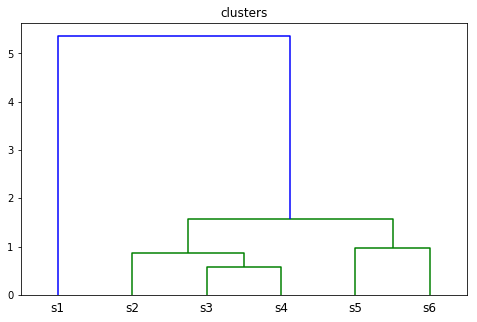

In [0]:
# transpose and convert solutions set to numpy
np_solutions_set = solutions_set_scaled.T.values
# calculate the distances
solutions_set_dist = pdist(np_solutions_set)
# hierarchical clusterization
linked = linkage(solutions_set_dist, 'ward')

# dendrogram
fig = plt.figure(figsize=(8, 5))
dendrogram(linked, labels = solutions_set_scaled.columns)
plt.title('clusters')
plt.show()

Text(0.5, 1.0, 'Submisions of s1 and s2')

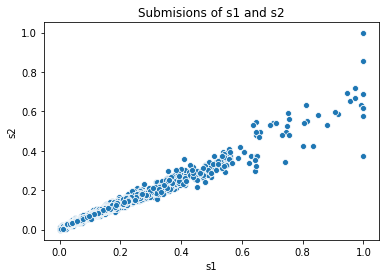

In [0]:
sns.scatterplot(x = 's1', y = 's2', data = solutions_set_scaled)
plt.title('Submisions of s1 and s2')

Text(0.5, 1.0, 'Submisions of s3 and s6')

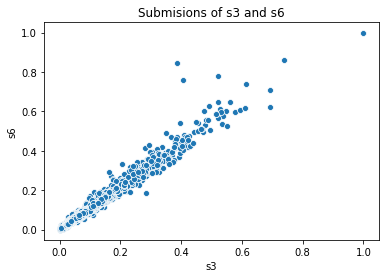

In [0]:
sns.scatterplot(x = 's3', y = 's6', data = solutions_set_scaled)
plt.title('Submisions of s3 and s6')

In [0]:
# get scaled submissions s1, s2 ... s7
for s in solutions_set_scaled.columns:
    s = solutions_set_scaled[s]
    
cluster1 = 1/3 * (s2 + s3 + s4)
cluster2 = 1/2 * (s5 + s6)

cluster3 = 0.5*cluster1 + 0.5*cluster2

submission['price'] = 0.3*s1 + 0.7*cluster3

#submission['price'] = 0.3*cluster1 + 0.7*cluster2

In [0]:
submission.to_csv('submission_final.csv', index=False)